# Classification
### MNIST
In this chapter, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is called the "Hello World" of machine learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST. Whenever someone learns ML, sooner or later they tackle MNIST.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code gets the MNIST dataset:

In [1]:
from sklearn.datasets import fetch_openml

# get the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
mnist.keyseys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:

- A `DESCR` key for describing the dataset
- A `data` key containing an array with one row per instance and one column per feature
- A `target` key containing an array with the labels

Let's take a look at these arrays:

In [3]:
X, y = mnist["data"], mnist["target"]

print("X's dimensions:", X.shape,"\ny's dimensions:", y.shape)

X's dimensions: (70000, 784) 
y's dimensions: (70000,)


There are 70,000 images, and each image has 784 features. This is because each image has 28x28 pixels, and each feature represents one pixel's intensity, from 0 (white) to 255 (black). Let's look at one image from the dataset:

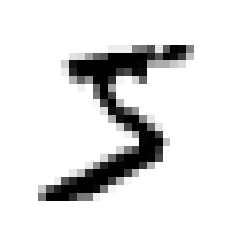

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

a_digit = X[0]
a_digits_img = np.array(a_digit).reshape(28, 28)

plt.imshow(a_digits_img, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()

Kind of looks like a 5...

In [6]:
y[0]

'5'

It is a 5. Note that the label is a string. We prefer numbers, so let's cast the y-array so that all the labels are integers:

In [7]:
y = y.astype(np.uint8)

We should always create a test set, and set it aside before inspecting the data closely here. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images). Cool...

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar. Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this will not happen.
### Training a Binary Classifier
Let's simplify the problem for now and only try to ID one digit-say a digit like the "5" we saw earlier. This is an example of a *binary classifier*, capable of distinguishing between a "5"-class and a "not 5"-class.

In [9]:
y_train_5 = (y_train == 5)  # True for all elements in the y_train vector equal to 5
y_test_5 = (y_test == 5)    # Similar definition as above

Okay, now let's pick a classifier and train it. A good place to start is with a *Stochastic Gradient Descent* classifier, using Scikit-Learn's `SGDClassifier` class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, as we will see later. Let's create an `SGDClassifier` and train it on the whole training set:

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=0)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=0)

Now we can use it to detect images of the number 5:

In [11]:
sgd_clf.predict([a_digit])

array([False])

Well, um, this classifier is not off to a great start here is it? (Recall, this should have returned `True`!)
### Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor. There are many performance measures available, so let's learn what some of the possiblities are!
#### Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation, just as we did in Chapter 2.

**Implementing Cross-Validation:**

Occasionally, we will need more control over the cross-validation process than what Scikit-Learn provides off-the-shelf. In these cases, we can implement cross-validation ourselves. The following code does roughly the same thing as Scikit-Learn's `cross_val_score()` function, and prints the same result:
```python
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 0)

for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_5[train_idx]
    X_test_fold = X_test[test_idx]
    y_test_fold = y_test_5[test_idx]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))              # Prints the proportion correct in each fold
```

*The `StratifiedKFold` class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.*

Let's use the `cross_val_score()` function to evaluate our `SGDClassifier` model using K-fold cross-validation, with three folds. Remember that K-fold cross-validation means splitting the training set into K-folds, then making predictions and evaluatiing them on each fold using a model trained on the remaining folds (Chapter 2 notebook).

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.9499, 0.9556, 0.966 ])

An accuracy of around 95%/96% sounds pretty good... or is it? (spoiler: it really isn't)

Let's say we take a classifier that classifies every single image in the "not 5"-class:

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

I would venture a guess that this model's accuracy is slightly above 90%.

In [14]:
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

Wow, who would have thunk it? A dataset that contains where around 90% of the data is not 5, and if we just guess that every written number is not a 5 we get around 90% accuracy.

Okay, but in all seriousness, accuracy may not be the best performance measure here. What
#### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the *confusion matrix*. The general idea is to count the number of times the instances of class A are classified as class B and vice versa. 

To compute the confusion matrix, we first need to have a set of predictions, so they can be compared to the actual targets. We could make predictions on the test set, but let's keep it untouched for now. Instead, we can use the `cross_val_predict()` function:

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

Just like the `cross_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that we get a clean prediction for each instance in the training set. Now we are ready to get the confusion matrix using the `confusion_matrix()` function. Just pass it the target classes `y_train_5` and the predicted classes `y_train_pred`:

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52931,  1648],
       [  922,  4499]])

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*. The first row of this matrix considers non-5 images (negative class). We see that 52,931 (*true negatives*) were correctly classified as non-5s, while the remaining 1,648 (*false positives*) were incorrectly classified as non-5s when in reality they were 5s. In the second row, we see that 922 5s were classified as non-5s (*false negatives*) and 4,499 5s were correctly classified as 5s (*true positives*). A perfect classifier would have returned a matrix that looked like this:
```python
array([[54579, 0],
       [0, 5421]])
```
The confusion matrix gives us a lot of information, but sometimes we may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions, known as the *precision* of a classifier:

$\ precision \ = \frac{TP}{TP+FP}$

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct. This would not be useful since the classifier would ignore all but one positive instance. So precision is typically used along with another metric called *recall*, also called *sensitivity* or *true positive rate (TPR)*. This is the ratio of positive instances that are correctly detected by the classifier:

$ \ recall \ = \frac{TP}{TP+FN}$
#### Precision and Recall
Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [17]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) # == 4499 / (4499 + 1648)
print(recall_score(y_train_5, y_train_pred))    # == 4499 / (4499 + 922)

0.7319017406865137
0.8299206788415422


Now, our 5-dectector does not look nearly as good as it did when we looked at its accuracy alone. When it claims an image represents a 5, it is only right approximately 73.2% of the time. Moreover, it only detects 5s approximately 83% of the time.

It is often conveinient to combine precision and recall into a single metric called the *F<sub>1</sub> score*, in particular if we need a simple way to compare two classifiers. The F<sub>1</sub> score is the *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally (but can be weighed by extremely high/low outlying values), the harmonic mean gives more weight to low values. As a result, the classifier will only get a high F<sub>1</sub> score if both recall and precision are high:

$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2(\frac{precision \ * \ recall}{precision \ + \ recall}) = \frac{TP}{TP + \frac{FN + FP}{2}}$

To compute the F<sub>1</sub> score, simply call the `f1_score()` function:

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.77783540802213

The F<sub>1</sub> score favors classifiers that have similar precision and recall. This is not always what we will want: in some instances we will care more about precision, while in others we will care more about recall. Unfortunately, we cannot simulataneously increase the precision and recall.
#### Precision/Recall Tradeoff
To understand this tradeoff, let's look at how the `SGDClassifier` makes its classification decisions. For each instance, it computes a score based on a *decision function*, and if that score is greater than a threshold, it assignes the instance to the positive class, or else it assigns it to the negative class. See illustration on pages 89-90.

Scikit-Learn does not let us se the threshold directly, but it does give us access to the decision scores that it uses to make predictions. Instead of calling the classifier's predict() method, we can call its `decision_function()` method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want:

In [19]:
y_scores = sgd_clf.decision_function([a_digit])
y_scores

array([-2736.11125406])

In [21]:
threshold = 0
y_a_digit_pred = (y_scores > threshold)
y_a_digit_pred

array([False])

The `SGDClassifier` uses a threshold equal to 0, so the previous code returns the same result as the `predict()` method. Let's raise the threshold:

In [23]:
threshold = -5000
y_a_digit_pred = (y_scores > threshold)
y_a_digit_pred

array([ True])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold would be lower, but it missed it when the threshold was 0. 

Now, what threshold do we use? For this we will first need to get the scores of all isntances in the training set using the `cross_val_predict()` function again, but this time specifying that we want it to return decision scores instead of predictions:

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

Now, with these scores we can compute the precision and recall for all possible thresholds using the `precision_recall_curve()` function:

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, we can plot precision and recall as functions of the trheshold value using Matplotlib:

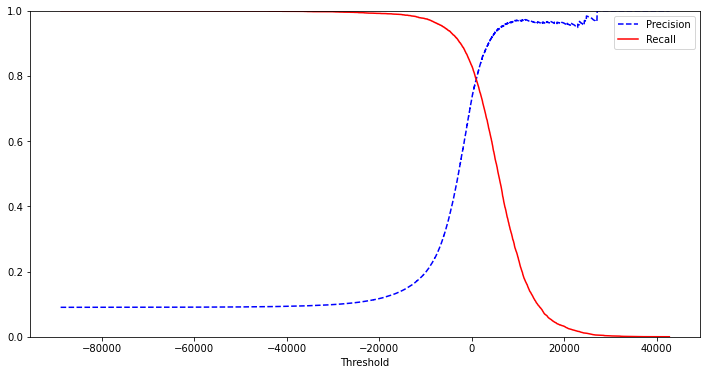

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize = (12, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "r-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend()
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

We can simply pick a threshold that gives us the best precision/recall tradeoff for our task. ANother way to select a good precision/recall tradeoff is to plot the precision directly against the recall:

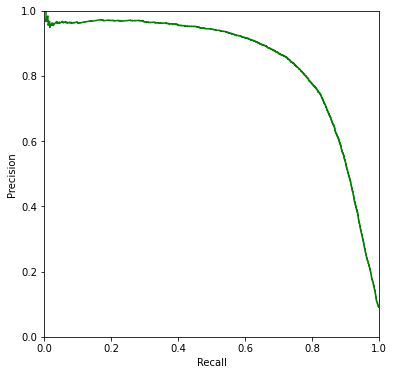

In [33]:
def plot_precision_vs_recall(recalls, precisions):
    plt.figure(figsize = (6, 6))
    plt.plot(recalls[:-1], precisions[:-1], "g-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0, 1]); plt.ylim([0, 1])

plot_precision_vs_recall(recalls, precisions)
plt.show()

We can see that the precision starts to fall off sharply around ~80% recall. We will probably want to select a precision/recall right before that drop, but, again, that depends on our project.

Let's suppose that we want to aim for 90% precision. We look up the the first plot and find we need a threshold of around 4,000. To make the predictions, instead of calling the classifier's `predict()` method, we can run this code:

In [42]:
y_train_pc_90_pred = (y_scores > 4000)

Let's check the precison and recall:

In [43]:
precision_score(y_train_5, y_train_pc_90_pred)

0.9107725788900979

In [44]:
recall_score(y_train_5, y_train_pc_90_pred)

0.6175982291090205

Well that's great, we have a 91% precision classifier. As we can see, it is easy to create a classifier with any precision, we just have to select a high enough threshold. HOWEVER, that classifier will be useless if the recall is too low!
#### The ROC Curve
The *receiver operating characteristic* (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the *true positive rate*, i.e. recall, against the *false positive rate*. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the *true negative rate*, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*. Hence the ROC curve plots *sensitivity* (recall) versus *1-specificity*.

To plot the ROC curve, we first need to compute the TPR and FPR for various threshold values, using the `roc_curve()` function:

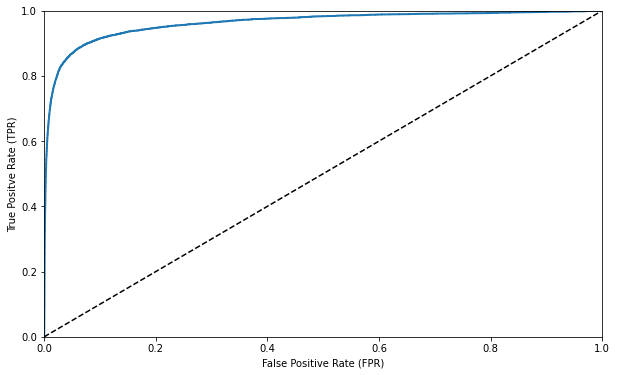

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Now plot the curve
def plot_roc_curve(fpr, tpr, label = None):
    plt.figure(figsize = (10, 6))
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positve Rate (TPR)")
    
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier. A good classifier stays as far away from that line as possible.

One way to compare classifers is to measure the *area under the curve* (AUC). A prefect classifer will have a *ROC AUC* equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [47]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624892334207759

Let's train a `RandomForestClassifier` and compare its ROC curve and ROC AUC score to the `SGDClassifier`. FIrst, we need to get scores for each instance in the training set. But due to the way it works, the `RandomForestClassifier` does not have a `decision_function()`. Instead it has a `predict_proba()` method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class:

In [48]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 0)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

But to plot a ROC curve, we need scores, not probabilities. A simple solution is to use the positive class's probability as a score... duh:

In [49]:
y_scores_forest = y_probas_forest[:, 1] # score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Let's compare these two classifiers:

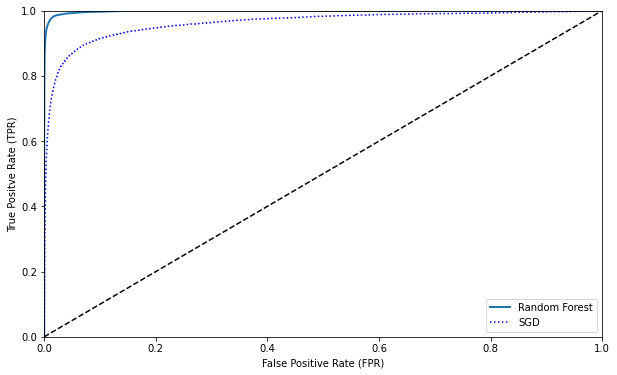

In [51]:
plot_roc_curve(fpr_forest, tpr_forest, label = "Random Forest")
plt.plot(fpr, tpr, "b:", label = "SGD")
plt.legend()
plt.show()

As we can see, the `RandomForestClassifier`'s ROC curve looks much better than the `SGDClassifier`'s. The ROC AUC will be better than the `SGDClassifier`'s ROC AUC as well:

In [52]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983139390673001

The precision and recall scores are higher too:

In [54]:
y_preds_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)
precision_score(y_train_5, y_preds_forest)

0.9905083315756169

In [55]:
recall_score(y_train_5, y_preds_forest)

0.8662608374838591

Let's try a mutlinomial classification problem now that we have a pretty darn good classifier.
### Multinomial Classification
Whereas binary classifiers distinguish between two classes, *multinomial classifiers* can distinguish between more than two classes. Some algorithms such as Random Forest classifiers or naive Bayes classifiers are capable of handling multiple classes directly. Others (such as SVCs or Linear classifiers) are strictly binary classifiers. However, there are various strategies that we can use to perform multinomial classification using multiple binary classifiers. 

We could make multiple classifiers that try to detect one specific class within the target space, known as a *one-versus-all strategy*. We could also train a binary classifier for every pair of classes, which would give us $\binom{n}{2} = \frac{n(n-1)}{2}$ classifiers, known as the *one-versus-one strategy*. In that instance, when we want to classify an image, we have to run the image through all the classifiers and see which class wins the most duels, which seems tedious.

Some algorithms, such as SVM classifiers  scale poorly with the size of the training set, so for these algorithms the one-versus-one strategy is perferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, the one-versus-all strategy is preferred.

Scikit-Learn detects when we try to use a binary classification algorithm for a multinomial classification task, and it automatically runs the one-versus-all strategy (except for SVM classifiers where it runs on a one-versus-one strategy). Let's try this with the `SGDClassifier`:

In [56]:
sgd_clf.fit(X_train, y_train)  # y_train_5 is changed to y_train
sgd_clf.predict([a_digit])

array([3], dtype=uint8)

That was fairly easy. The code trains the `SGDClassifier` on the training set using the original target classes from 0 to 9 (the `y_train` vector). Then it makes a prediction (the wrong one). Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

To see that this is the case, we can call the `decision_function()` method. Instead of returning one score per instance, it now returns 1 score per class (10 scores).

In [57]:
a_digit_scores = sgd_clf.decision_function([a_digit])
a_digit_scores

array([[-13236.09081562, -19699.08846458,  -8139.68842023,
           930.53889974, -20705.22636106,  -1184.44579435,
        -35313.70462583, -12156.5587882 , -10657.65460373,
        -10403.33370535]])

We see that 5 was the second most likely, so I guess that it wasn't too far off. The highest score coresponded to 3:

In [58]:
np.argmax(a_digit_scores)

3

In [59]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [60]:
sgd_clf.classes_[3]

3

If we want to force Scikit-Learn to use the OvO strategy or the OvA strategy, we can use the `OneVsOneClassifier` or the `OneVsRestClassifier` classes. Simply create an instance and pass a binary classifier to its constructor. For example, this code creates a multinomial classifier using the OvO strategy based on a `SGDClassifier`:
```python
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 0))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([a_digit])
# Returns the OvO prediction
len(ovo_clf.estimators_)
# Returns 45 in this instance
```
Training a `RandomForestClassifier` is just as easy:

In [61]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([a_digit])

array([5], dtype=uint8)

Hey, this time it correctly predicted that the digit was 5! This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes. We can call `predict_proba()` to get the list of probabilities that the classifier assigned to each instance for each class:

In [62]:
forest_clf.predict_proba([a_digit])

array([[0.  , 0.  , 0.01, 0.06, 0.  , 0.87, 0.02, 0.01, 0.02, 0.01]])

The model is pretty confident (87% likelihood), that this image represents a 5. It also thinks it could be a 2, 3, 6, 7, 8, or 9, but those probabilities are very low by comparison.

Now we want to evaluate these classifiers. As usual, we want to use cross validation. Let's evaluate the `SGDClassifier`'s accuracy using the `cross_val_score()` function:

In [63]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.8485, 0.8676, 0.8621])

The accuracy comes in between 84-87% on all the test folds. If we used a random classifier, we would get around 10% accuracy, which means that this is not a terrible score. With the `RandomForestClassifier`, we see that the overall performance was better:

In [64]:
cross_val_score(forest_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.96465, 0.96225, 0.9659 ])

We can still do better. For example, scaling the inputs would increase the accuracy of the `SGDClassifier` to ___:

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy", n_jobs = 3)

/home/evan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([0.89935, 0.9016 , 0.9017 ])

### Error Analysis
Of course, we would need to folow the steps in our ML project checklist (see Appendix B): exploring data preparation options, trying multiple models, shortlisting the best ones and fine-tuning their hyperparameters using `GridSearchCV` or `RandomSearchCV`, and automating as much as possible, as we did in Chapter 2. Here, we will assume that we have found a promising model and we want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First, we can look at the confusion matrix. We need to make predictions using the `cross_val_predict()` function, then call the `confusion_matrix()` function, just as we did earlier:

In [69]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3, n_jobs = 3)
conf_mtx = confusion_matrix(y_train, y_train_pred)
conf_mtx

/home/evan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([[5584,    0,   21,    6,    8,   50,   38,    7,  208,    1],
       [   1, 6411,   36,   27,    4,   43,    4,    8,  196,   12],
       [  28,   26, 5257,   95,   71,   28,   67,   38,  341,    7],
       [  27,   19,  119, 5249,    1,  218,   27,   41,  359,   71],
       [  12,   16,   49,    9, 5207,   12,   37,   28,  299,  173],
       [  28,   16,   30,  176,   53, 4514,   76,   18,  445,   65],
       [  30,   17,   42,    2,   42,   99, 5562,    3,  120,    1],
       [  19,   10,   54,   30,   49,   15,    3, 5710,  156,  219],
       [  20,   64,   47,   90,    3,  125,   25,   10, 5421,   46],
       [  23,   20,   30,   65,  124,   38,    1,  184,  326, 5138]])

These numbers would probably be hard to parse through. We should try creating a visualization of this confusion matrix. This can be done using Matplotlib's `matshow()` function:

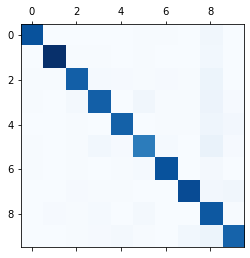

In [70]:
plt.matshow(conf_mtx, cmap = plt.cm.Blues)

This confusion matrix looks pretty good, since most of the images are on the main diagonal, which means thaat they were classified correctly for the most part. Add analysis here

Let's focus the plot on the errors. First, we need to divide each value in the confusion matrix by the number of images in the corresponding class, so we can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad):

In [74]:
row_sums = conf_mtx.sum(axis = 1)
norm_conf_mtx = conf_mtx / row_sums

Now let's fill the diagonal with zeros to keep only the erors, and let's plot the result:

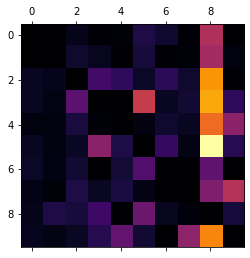

In [77]:
np.fill_diagonal(norm_conf_mtx, 0)
plt.matshow(norm_conf_mtx, cmap=plt.cm.inferno)
plt.show()

Now we can see the kinds of errors the classifier makes. Remember that the **rows represent the actual classes, while the columns represent the predicted classes.** The columns for 8 and 9 are particularly bright, so we need to improve classification of those two digits. There also seems to be some confusion between 3/5, 4/9, and 7/9.

Analyzing the confusion matrix can often give us insights on ways to improve our classifier. Looking at this plot, it seems that our effects should be spent on improving the classification of 8s and 9s, as well as fixing the specific 3/5 confusionn. For example, we could try to gather more training data for these digits. Or we could engiiner new features that would help the classifier-such as writing an algorithm to count the number of closed loops (such as 8 having 1, 6 having two, and 5 having none). Or we could preprocess the images (using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

Analyzing individual erros can also be a good way to gain insights on what our classifier is doing and why it is failing, but it is more difficult and time-consuming. For example, let's plot some 3s and 5s:

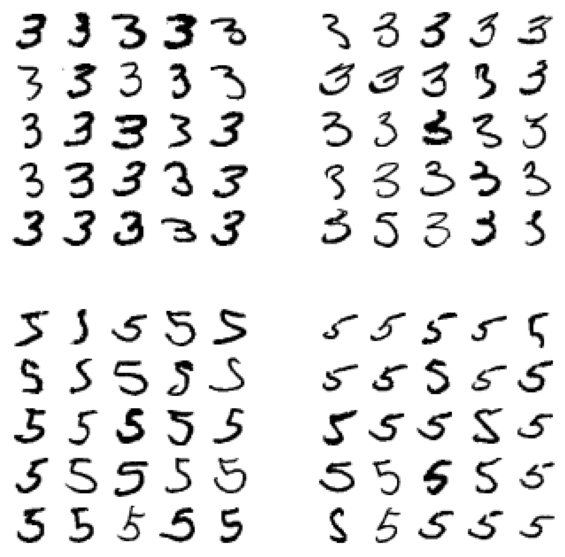

In [78]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

# Plot the images
plt.figure(figsize = (10, 10))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

The two 5x5 blocks on the left show digits classified as 3s, and the two blocks on the right show digits classified as 5s. Some digits that the classifier gets wrong are are poorly written that even we would have trouble making out what the number is. However, some misclassified errors don't make sense (lower left block, first column, bottom 3 entries, for example). The reason is that we used a version of a linear classifier. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class.

The main difference between 3s and 5s is the position of the small line that joins the top line and the bottom arc. If we make an extra small mark on a 3 or 5, it is easy to see how the model would make the 3/5 classification mistake. Another thing we can do is to preprocess the images by well-centering them and making sure that they are not too rotated. This will probably help reduce errors too.
### Multilabel Classification